In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#survival analysis lib
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import restricted_mean_survival_time, k_fold_cross_validation, qth_survival_times, median_survival_times


In [68]:
#dummfiied elsewhere
telco = pd.read_csv('../data/telco_clustered.csv')
cust_id = pd.read_csv('../data/telco_final.csv')
pd.set_option('display.max_columns',99)

In [69]:
telco.head()

,gender,age,under_30,senior_citizen,married,dependents,number_of_dependents,city,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,churn_value,churn_score,cltv,churn_reason,referred_a_friend,number_of_referrals,offer,avg_monthly_long_distance_charges,internet_type,avg_monthly_gb_download,streaming_music,unlimited_data,monthly_charge,total_charges,total_refunds,total_extra_data_charges,total_long_distance_charges,total_revenue,satisfaction_score,customer_status,churn_category,pop_density,new_user,cluster
0,0,78,0,1,0,0,0,Los Angeles,1,0,0,DSL,0,0,1,0,0,1,Month-to-month,1,Electronic check,1,100,5433,Competitor offered more data,0,0,None,0.00,DSL,8,0,0,39.65,39.65,0.00,20,0.00,59.65,3,1,Competitor,15334,0,vanilla
1,1,74,0,1,1,1,1,Los Angeles,8,1,1,Fiber optic,0,1,0,0,0,0,Month-to-month,1,Credit card (automatic),1,69,5302,Competitor made better offer,1,1,Offer E,48.85,Fiber Optic,17,0,1,80.65,633.30,0.00,0,390.80,1024.10,3,1,Competitor,17038,0,price_sensitive
2,0,71,0,1,0,1,3,Los Angeles,18,1,1,Fiber optic,0,0,0,0,1,1,Month-to-month,1,Electronic check,1,81,3179,Competitor made better offer,0,0,Offer D,11.33,Fiber Optic,52,1,1,95.45,1752.55,45.61,0,203.94,1910.88,2,1,Competitor,8625,0,price_sensitive
3,1,78,0,1,1,1,1,Inglewood,25,1,0,Fiber optic,0,1,1,0,1,1,Month-to-month,1,Electronic check,1,88,5337,Limited range of services,1,1,Offer C,19.76,Fiber Optic,12,0,1,98.50,2514.50,13.43,0,494.00,2995.07,2,1,Dissatisfaction,11799,0,price_sensitive
4,1,80,0,1,1,1,1,Whittier,37,1,1,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,1,67,2793,Extra data charges,1,1,Offer C,6.33,Fiber Optic,14,0,1,76.50,2868.15,0.00,0,234.21,3102.36,2,1,Price,6947,0,price_sensitive


In [70]:
telco['cust_id'] = cust_id['customer_id']

## Survival Analysis

measures the estimated death with right censorship 

### Kaplan Meier

Estimation of survival function 

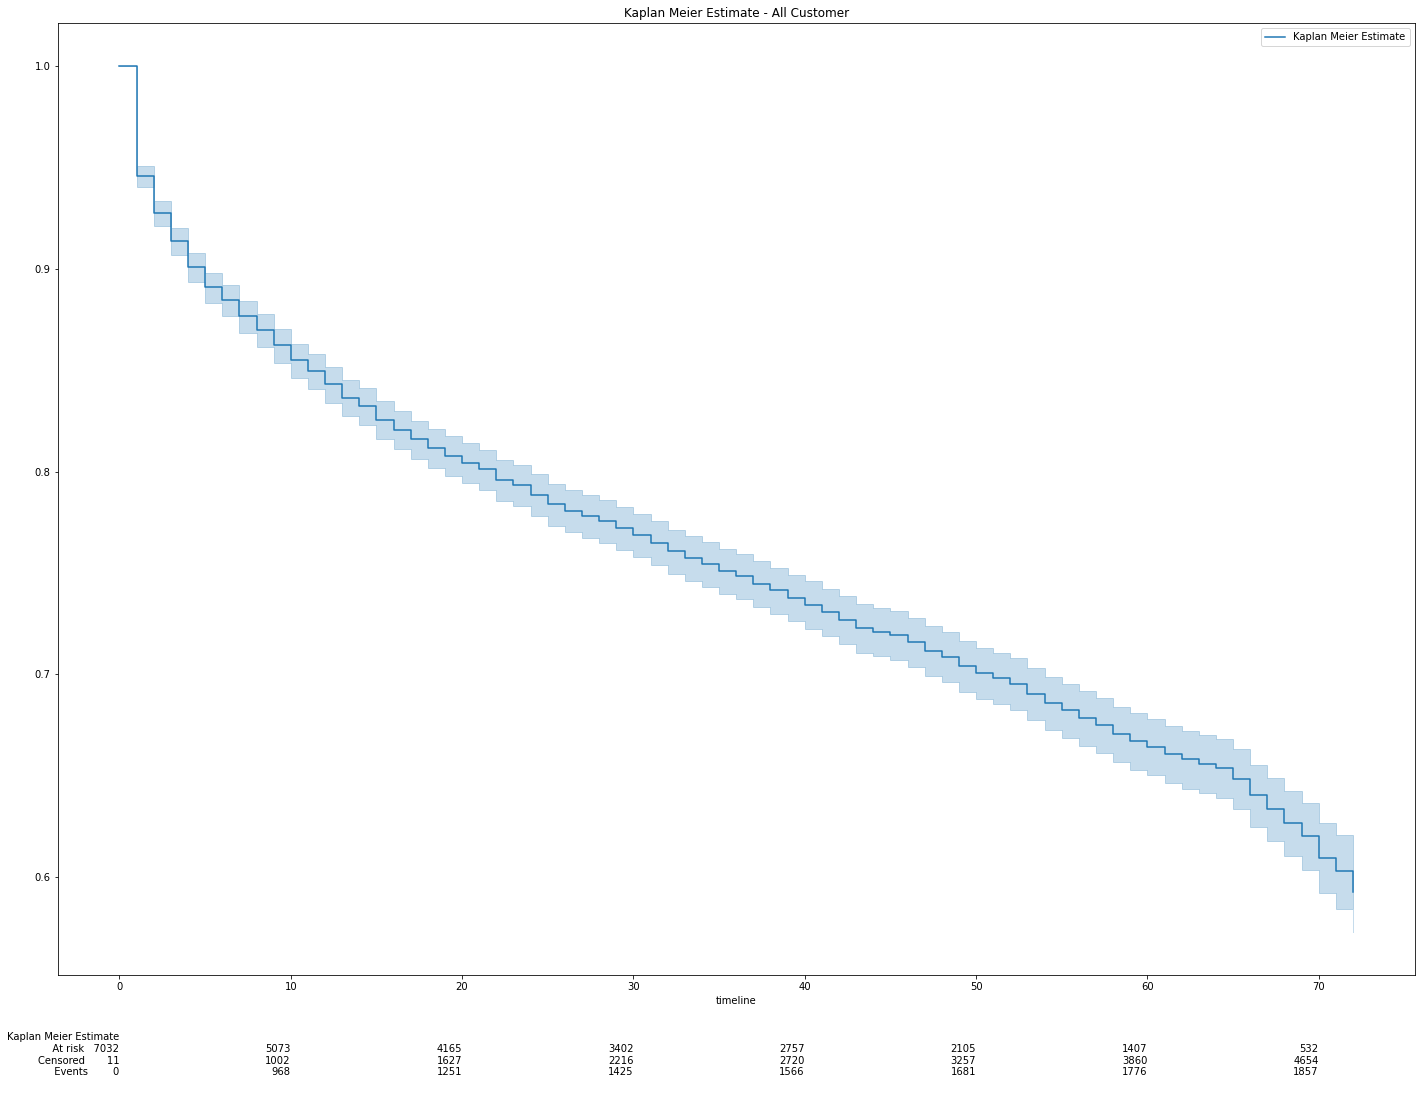

In [3]:
duration = telco['tenure_months'] 
event_observed = telco['customer_status']  

# instantiate km
km = KaplanMeierFitter() 

#plot figure
plt.figure(figsize=(20,15))
# Fit
km.fit(duration, event_observed,label='Kaplan Meier Estimate')

# Create an estimate
km.plot_survival_function(at_risk_counts=True)

plt.title('Kaplan Meier Estimate - All Customer')
plt.show()

Retention over 60% at 72 months 

At-risk: number of customers with an observed tenure of more than the point in time. For example, 532 customers had a tenure of more than 70 months

Censored: number of customers with a tenure equal to or less than the point in time, which were not churned. For example, 3,860 customers had a tenure of 60 months or less However, they had not churned then

Events: number of customers with a tenure equal to or less than the point in time, which had churned by then. For example, 1,681 customers had a tenure of 50 months or less and had churned by then

In [4]:
km.median_survival_time_

inf

## Cohorts

In [5]:
telco.cluster.value_counts(normalize=True)

price_sensitive    0.275309
vanilla            0.255573
heavyweight        0.252307
minimalist         0.216811
Name: cluster, dtype: float64

In [21]:
def plot_categorical_KM_Curve(feature, t='tenure_months', event='customer_status', df=telco, ax=None):
    '''function to plot kmcurve'''
    #instantiater
    kmf = KaplanMeierFitter() 
    
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        rmst = restricted_mean_survival_time(kmf, t=time_limit)
        print(f'Restricted Mean Survival Time ({cat}): {rmst}')
        kmf.plot(ax=ax, label=cat)

Restricted Mean Survival Time (vanilla): 38.913504228425595
Restricted Mean Survival Time (price_sensitive): 24.46693462293565
Restricted Mean Survival Time (heavyweight): 49.757277333026366
Restricted Mean Survival Time (minimalist): 46.51885717339057


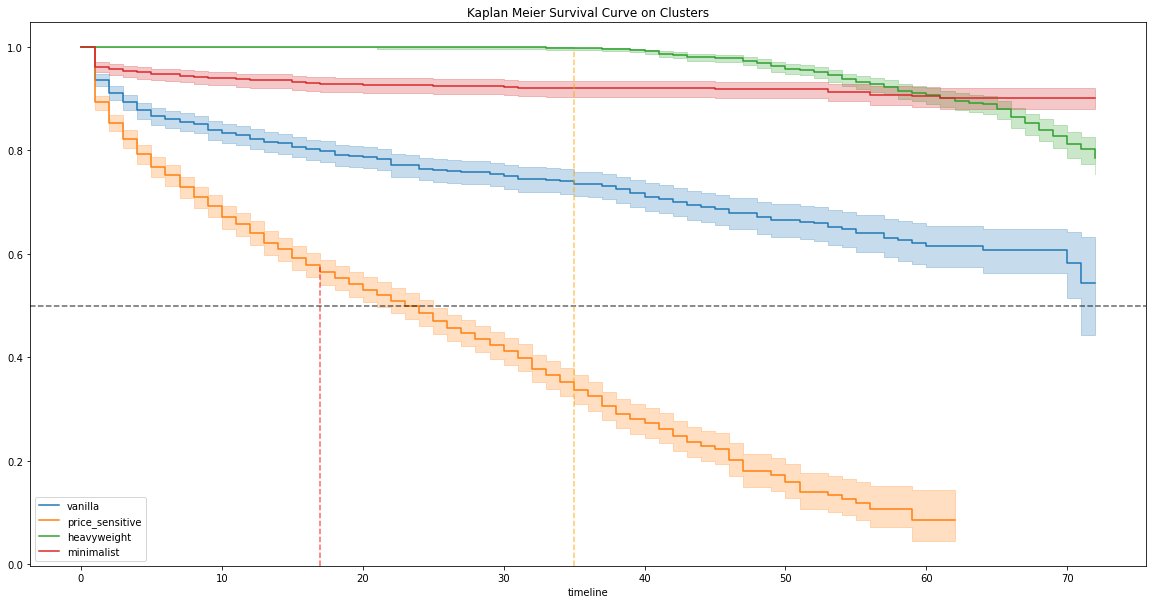

In [22]:
plt.subplots(nrows = 1, ncols = 1, figsize=(20,10))

time_limit = 50
#plot km curve by cluster
plot_categorical_KM_Curve(feature='cluster',t='tenure_months', event='customer_status', df=telco, ax=None)

plt.axhline(y=0.5, c='k', alpha=0.6, linestyle='--')
plt.title('Kaplan Meier Survival Curve on Clusters')
plt.legend(loc='lower left')
plt.axvline(x=17, ymax=0.55,c='r', alpha=0.6, linestyle='--')
plt.axvline(x=35,ymax=0.95, c='orange', alpha=0.6, linestyle='--')

plt.show()

## Test other categorical 

In [23]:
kmf_col = ['internet_service','offer','contract','payment_method']

Restricted Mean Survival Time (DSL): 42.161916637798896
Restricted Mean Survival Time (Fiber optic): 35.81276124981554
Restricted Mean Survival Time (No): 46.51620587512882
Restricted Mean Survival Time (None): 39.77996264614296
Restricted Mean Survival Time (Offer E): 14.14870869282533
Restricted Mean Survival Time (Offer D): 32.27038001842844
Restricted Mean Survival Time (Offer C): 40.60036377108066
Restricted Mean Survival Time (Offer B): 49.661933943077514
Restricted Mean Survival Time (Offer A): 50.0
Restricted Mean Survival Time (Month-to-month): 30.093045969230236
Restricted Mean Survival Time (One year): 48.573593848056845
Restricted Mean Survival Time (Two year): 49.95411186614056
Restricted Mean Survival Time (Electronic check): 32.30061079124188
Restricted Mean Survival Time (Credit card (automatic)): 45.76070150465541
Restricted Mean Survival Time (Mailed check): 40.28097482340509
Restricted Mean Survival Time (Bank transfer (automatic)): 45.299264500404604


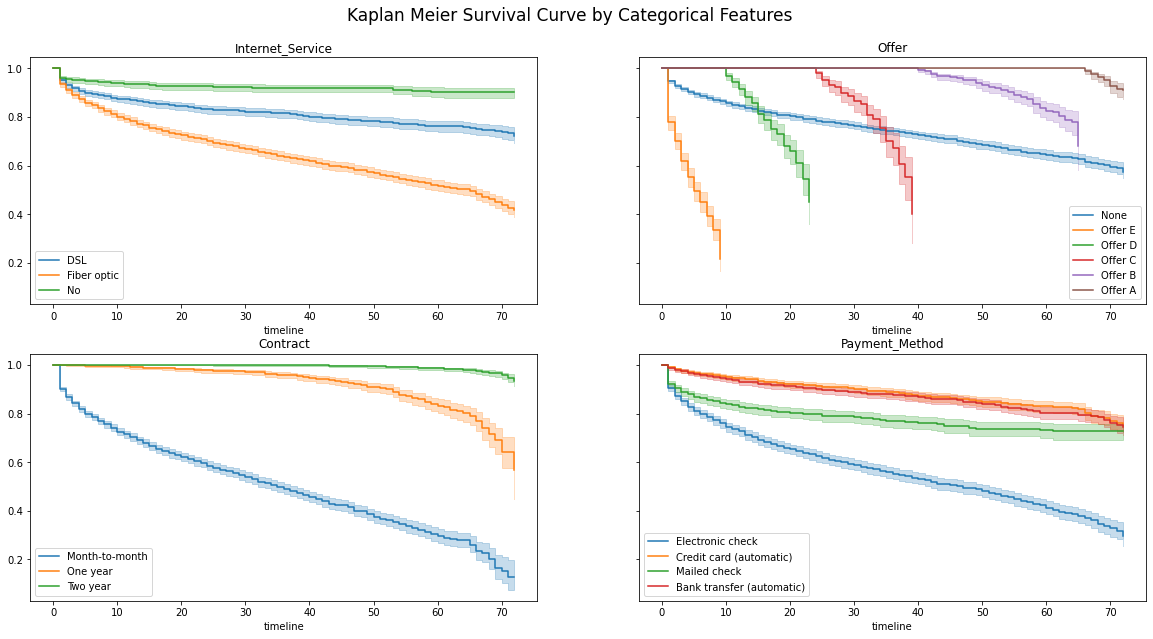

In [24]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(20,10), sharex=False, sharey=True)
ax = ax.flatten()

for idx, col in enumerate(kmf_col):
    #instantiater
    kmf = KaplanMeierFitter() 
    #plot km curve by cluster
    plot_categorical_KM_Curve(feature=col,t='tenure_months', event='customer_status', df=telco, ax=ax[idx])
    ax[idx].set_title(col.title())

plt.suptitle('Kaplan Meier Survival Curve by Categorical Features', y=0.95, fontsize=17)
plt.show()

Internet Service - fibre optic churn higher than DSL and no internet service. however likely as more users are fibre optics, this is important to investigate root cause

Offer - Offer E and D shorter survival rate

Contract - higher churn on month to month 

Payment method - bank trasnfer and credit card higher survival rate

### Cox Proportional Hazard Model 

Association between the survival time of customer and one or more predictor variables. between covairates (given ratio between groups)

assumptions
1. non information censoring, 
2. survival times are independent
3. hazard ratio constant - check with clog log or schoenfldt
4. log hazard func is linear function of the X's (numerical)  - residual plot/weibull
5. value of X dont change over time
6. baseline hazard is unspecified 

In [25]:
telco.columns

Index(['gender', 'age', 'under_30', 'senior_citizen', 'married', 'dependents',
       'number_of_dependents', 'city', 'tenure_months', 'phone_service',
       'multiple_lines', 'internet_service', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'contract', 'paperless_billing', 'payment_method',
       'churn_value', 'churn_score', 'cltv', 'churn_reason',
       'referred_a_friend', 'number_of_referrals', 'offer',
       'avg_monthly_long_distance_charges', 'internet_type',
       'avg_monthly_gb_download', 'streaming_music', 'unlimited_data',
       'monthly_charge', 'total_charges', 'total_refunds',
       'total_extra_data_charges', 'total_long_distance_charges',
       'total_revenue', 'satisfaction_score', 'customer_status',
       'churn_category', 'pop_density', 'new_user', 'cluster'],
      dtype='object')

In [26]:
cph = CoxPHFitter()

cph.fit(telco, duration_col='tenure_months', event_col='customer_status', 
       formula="gender + senior_citizen + married + number_of_dependents + phone_service + multiple_lines + internet_service + online_security + online_backup + device_protection + tech_support + streaming_tv + streaming_movies + contract + paperless_billing + payment_method + number_of_referrals + offer + monthly_charge")


<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>

less than 0.05 is statistically significant difference.denotes that we have to reject our null hypothesis and admit that the survival function for both groups is significantly different.

In [153]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure_months'
                event col = 'customer_status'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -13288.83
         time fit was run = 2021-05-18 07:46:35 UTC

---
                                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                         
contract[T.One year]                       -1.46       0.23       0.09            -1.63            -1.28                 0.20                 0.28
contract[T.Two year]                       -3.05       0.05       0.17            -3.38            -2.71                 0.03                 0.07
device_protection                          -0.23       0.80       0.13            -0.48             0.02                 0.62                 1.02
gender                                      0.06       1.07       0.05            -0.03             0.16                 0.97                 1.17
internet_service[T.Fiber optic]             0.42       1.52       0.58            -0.73             1.56                 0.48                 4.78
internet_service[T.No]                     -1.11       0.33       0.59            -2.28             0.05                 0.10                 1.06
married                                     0.49       1.63       0.06             0.36             0.61                 1.44                 1.84
monthly_charge                             -0.00       1.00       0.02            -0.05             0.04                 0.95                 1.04
multiple_lines                             -0.32       0.72       0.13            -0.58            -0.07                 0.56                 0.93
number_of_dependents                       -0.36       0.70       0.05            -0.46            -0.26                 0.63                 0.77
number_of_referrals                        -0.37       0.69       0.02            -0.42            -0.32                 0.66                 0.72
offer[T.Offer A]                           -1.16       0.31       0.18            -1.52            -0.81                 0.22                 0.45
offer[T.Offer B]                           -1.08       0.34       0.11            -1.29            -0.87                 0.27                 0.42
offer[T.Offer C]                           -0.46       0.63       0.11            -0.68            -0.25                 0.51                 0.78
offer[T.Offer D]                            0.03       1.03       0.09            -0.14             0.21                 0.87                 1.23
offer[T.Offer E]                            1.56       4.75       0.07             1.42             1.70                 4.12                 5.48
online_backup                              -0.52       0.60       0.13            -0.77            -0.26                 0.46                 0.77
online_security                            -0.51       0.60       0.13            -0.77            -0.25                 0.46                 0.78
paperless_billing                           0.18       1.19       0.06             0.06             0.29                 1.07                 1.33
payment_method[T.Credit card (automatic)]  -0.09       0.92       0.09            -0.26             0.09                 0.77                 1.10
payment_method[T.Electronic check]          0.42       1.53       0.07             0.28             0.57                 1.33                 1.76
payment_method[T.Mailed check]              0.49       1.63       0.09             0.31             0.66                 1.37                 1.94
phone_service                               0.13       1.14       0.48            -0.80   

exp(coef) , less than 1 lower risk of death, longer median survival. (hazard ratio)

coef is the difference in log hazard func between two group (log instantaneous risk of death, is coef higher than other X. 

coef lower 95 and upper 95 is confidence interval to baseline hazard of death -1.19 times more -0.83 



Model coefficients (coef column) tell us how each covariate impacts risk. A positive coef for a covariate indicates that a customer with that feature is more likely to churn and vice versa

exp(coef) is the hazard ratio, interpreted as the scaling of hazard risk for each additional unit of the variable, with 1.00 being neutral. For example, the 1.332 hazard ratio for StreamingMovies means a customer who is subscribed to a streaming movie service is 33.2% more likely to cancel their service. From our perspective, exp(coef) below 1.0 is good, meaning a customer is less likely to cancel in the presence of that covariate


Model Concordance of 0.929 is interpreted similarly to a logistic regression’s AUROC: 
— 0.5 is the expected result from a random prediction
— closer to 1.0, the better with 1.0 showing a perfect predictive concordance.

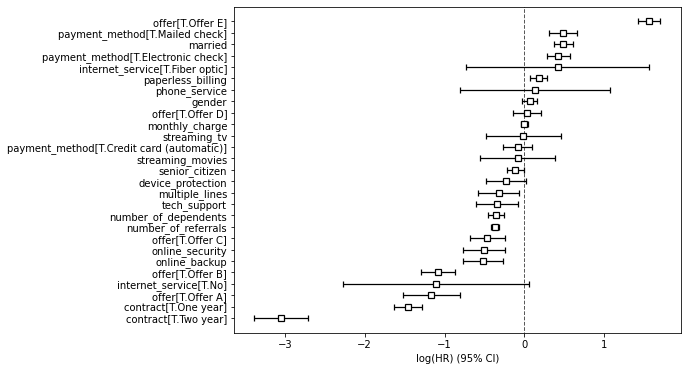

In [28]:
ax = plt.subplots(figsize=(8, 6))
cph.plot(ax=ax[1])
plt.show()

contract two year less likely to churn compared to none and one year.

offer A vs Offer E, 


## Quadrant division

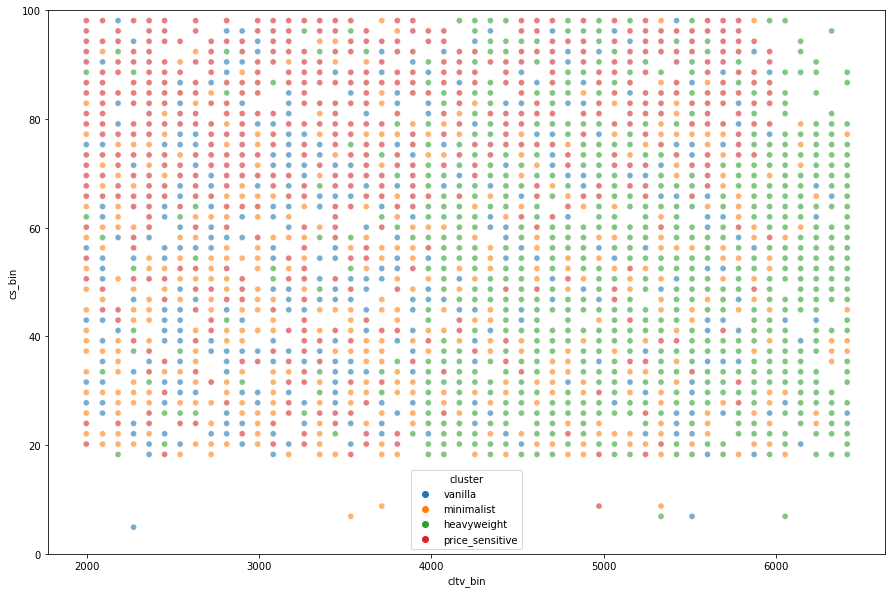

In [41]:
telco_quadrant = telco[['cltv','churn_score','cluster','satisfaction_score']].copy()
telco_quadrant['cs_bin'] = pd.cut(telco_quadrant['churn_score'], bins=50).apply(lambda x: x.left)
telco_quadrant['cltv_bin'] = pd.cut(telco_quadrant['cltv'], bins=50).apply(lambda x: x.left)
plot_df = telco_quadrant.groupby(['cs_bin', 'cltv_bin']).agg({'cluster': lambda x: x.mode()[0]}).reset_index()

plt.figure(figsize=(15,10))
sns.scatterplot(data=plot_df, x='cltv_bin',y='cs_bin', hue='cluster', alpha=0.6)
plt.ylim(0, 100)
plt.show()